# Exercices

With each exercice will teach you one aspect of deep learning.
The process of machine learning can be decompose in 7 steps :

1. Data preparation
2. Model definition
3. Model training
4. Model evaluation
5. Hyperparameter tuning
6. Prediction

## Basic preparation

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

## Data wrangling

Generating the right format for face landmarks

In [3]:
landmarks = []

import os
for k in range(0,6):
    sub = 'CAT_0'+str(k)
    directory = 'cats/'+sub

    image_name = []
    image_landmarks = []
    for filename in os.listdir(directory):
        if filename.endswith(".cat"): 
            image_name.append(filename.replace('.cat',''))
            with open(os.path.join(directory, filename)) as f:
                content = str(f.readlines()).replace("'","").replace("[","").replace("]","").split(' ')
                landmarks = {}
                for i in range(1, 10, 1):
                    #print(i, content[i], content[i+1])
                    landmarks['part_'+str(i-1)+'_x'] = int(content[2*i-1])
                    landmarks['part_'+str(i-1)+'_y'] = int(content[2*i])
                image_landmarks.append(landmarks)


    # image_name,part_0_x,part_0_y,part_1_x
    d = {'image_name':image_name, 'image_landmarks':image_landmarks}
    df = pd.DataFrame(image_landmarks)
    df['image_name'] = image_name

    df.to_csv('cats/'+sub+'_landmarks.csv', sep=',', encoding='utf-8')

## 0 - Data acquisition

from https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

* Load CSV providing features on data
* Loading image data
* Visualising features on images
* Creating a dataset
* Creating transform and applying these on the dataset

In [4]:
landmarks_frame = pd.read_csv('cats/CAT_00_landmarks.csv')

#print(landmarks_frame.head())

n = 915
img_name = landmarks_frame['image_name'][n]
landmarks = landmarks_frame.iloc[n,1:19].as_matrix()
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('Landmarks: {}'.format(landmarks))

Image name: 00000417_018.jpg
Landmarks shape: (9, 2)
Landmarks: [[196. 120.]
 [247. 126.]
 [239. 168.]
 [127.  97.]
 [146.  15.]
 [190.  66.]
 [227.  71.]
 [269.  30.]
 [259. 113.]]


Visualization of face features on image. Nice to get understanding of the dataset.

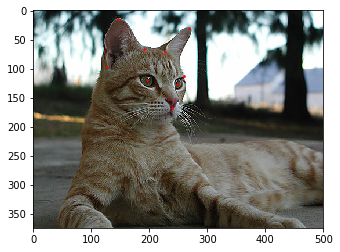

In [5]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_landmarks(io.imread(os.path.join('cats/CAT_00/', img_name)), landmarks)
plt.show()

Pytorch wrapper for a specific dataset: handle data loading and transformation pipelines.

In [6]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame['image_name'][idx])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:19].as_matrix()
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

Apply it on your data and shocase the results.

0 (500, 462, 3) (9, 2)


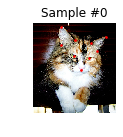

1 (375, 500, 3) (9, 2)


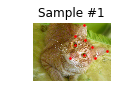

2 (1024, 660, 3) (9, 2)


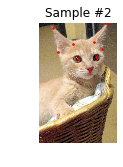

3 (456, 500, 3) (9, 2)


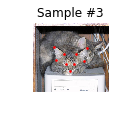

In [7]:
face_dataset = FaceLandmarksDataset(csv_file='cats/CAT_00_landmarks.csv',
                                    root_dir='cats/CAT_00/')

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

Play with your inputs to adapt it to the network architecture: use transformer pipeline to modify, enhance, normalize...

In [8]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

Apply and play with different version of the transformations. Visualize the effects to ensure everything is fine (and that the core of the data distribution is kept).

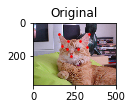

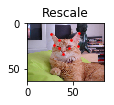

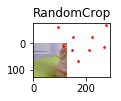

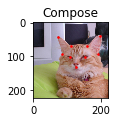

In [9]:
scale = Rescale(64)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[98]

ax = plt.subplot(1, 4, 1)
plt.tight_layout()
ax.set_title('Original')
show_landmarks(**sample)

for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 4, i + 2)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

Then simply apply on the whole dataset. It's now ready to bake.

In [10]:
transformed_dataset = FaceLandmarksDataset(csv_file='cats/CAT_00_landmarks.csv',
                                           root_dir='cats/CAT_00/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([9, 2])
1 torch.Size([3, 224, 224]) torch.Size([9, 2])
2 torch.Size([3, 224, 224]) torch.Size([9, 2])
3 torch.Size([3, 224, 224]) torch.Size([9, 2])


Again check the results (always chck the results).

0 torch.Size([4, 3, 224, 224]) torch.Size([4, 9, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 9, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 9, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 9, 2])
4 torch.Size([4, 3, 224, 224]) torch.Size([4, 9, 2])
5 torch.Size([4, 3, 224, 224]) torch.Size([4, 9, 2])


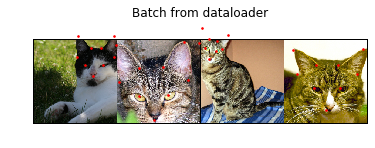

In [11]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)


# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 5:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break